# Heat diffusion with a (photothermal) heating source in 1D-cylindrical geometry

version 230817, MW

## Introduction

A weakly focussed Gaussian laser beam traverses a medium (typically a liquid containing a dye or other light-absorbing substances). The laser light is partially absorbed by the medium, leading to local heating (Naperian absorption coefficient $\alpha$). A quantitative idea of the temperature distribution in this system can be obtained by a mathematical model.

Near the focal point, the width of the Gaussian laser beam may assumed to be constant, in which case we can write a heat equation in 1D cylindrical geometry, where the temperature is considered to spatially vary only as the radial position $r$ with respect to the propagation axis of the light. There is also a time dependence, since we "switch on" the laser at $t = 0$.

With $T$ the change in temperature and $\dot q(r)$ the radial distribution of photothermal heat generation, the equations modeling this system can be written as follows [1]

$$
c \rho \frac{\partial T(r, t)}{\partial t} = \dot q(r) + k \nabla^2 T(r, t)
$$

$$
r \in [0, +\infty\rangle
$$

$$
T(r, t=0) = 0
$$

The heat source term $\dot q(r)$ is obtained from the laser beam intensity $S(r)$ and the absorption coefficient $\alpha$.

$$ \dot q(r) = \alpha S(r) = \frac{2\alpha P}{\pi w^2}
\exp \left( \frac{-2r^2}{w^2}\right)
$$

**to do.** Give more attention to absorption coefficent $\alpha = \ln(10)\textrm{OD}/l$, see [2]. For now, $\alpha$ will be set to $1$ throughout.

## Literature references

[1] Sheldon, S. J., Knight, L. V., & Thorne, J. M. (1982). Laser-induced thermal lens effect: a new theoretical model. Applied optics, 21(9), 1663-1669.

[2] Carter, C. A., & Harris, J. M. (1984). Comparison of models describing the thermal lens effect. Applied optics, 23(3), 476-481.

[3] Boudebs, G. (2021). Numerical simulation of the whole thermal lensing process with Z-scan-based methods using Gaussian beams. Materials, 14(19), 5533.

[5] https://nines.cs.kuleuven.be/software/QUADPACK/

[6] https://www.netlib.org/quadpack/changes


## Analytic solutions

Several different yet equivalent expressions have been reported as an analytic solution of the heat equation above. One form employs exponential integrals [2], whereas another form uses a simplified integral expression [1][3].

Here we demonstrate that both expressions are equivalent, except that the exponential integral formulation diverges at $r=0$, whereas the simplified integral expression does not. Quantitative investigation of both expressions from literature is also a good demonstration of how to evaluate analytic expressions numerically using the `scipy` and `numpy`.

Where necessary the expressions from literature have been adapted to use SI units exclusively.

In [1]:
import numpy as np
from numpy import pi, exp
from scipy.special import expi
from scipy.integrate import quad
import matplotlib.pyplot as plt

First, we encode the expression for the Gaussian laser beam intensity distribution.

In [2]:
def S(r, P, w):
  return (2*P)/(pi*w**2) * exp(-2*r**2/w**2)

We immediatly initialize the model system parameters to experimentally realistic values. 

In [3]:
P = 1.0e-3 # 1 mW
w = 50e-6 # 50 µm waist
k = 0.598 # W/(m.K)
rho = 998.23 # kg/m3
cp = 4184. # J/(K.kg)

From these, we have the characteristic time $t_c$.

In [4]:
t_c = (w**2*cp*rho)/(4*k)

In [5]:
print(f't_c = {t_c*1000.:.3f} ms')

t_c = 4.365 ms


The laser beam profile is plotted for illustration.

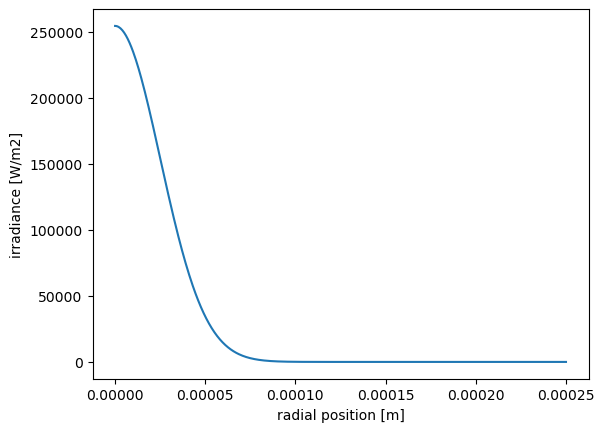

In [6]:
rrx = np.linspace(0, w*5, 500)
plt.plot(rrx, S(rrx, P, w))
plt.ylabel('irradiance [W/m2]')
plt.xlabel('radial position [m]'); # semicolon to avoid print text object descriptor to output 

The exponential integral expression [2]  is easily evaluated using the `expi` special function routine from `scipy.special`. It will be referred to as 'Carter1984'.

In [7]:
def DeltaT_Carter(r, t, P, w, k, t_c):
    """
    Carter1984 expression
    """
    alpha = 1.0 # for now. TODO
    A = 1/(4*pi*k)
    B = P*alpha
    C = expi(-2*r**2/w**2) - expi(((-1/(1 + 2*t/t_c)) * (2*r**2/w**2)))
    return A*B*C

Accurate evaluation of the simplified integral expression [1] (which does not diverge at $r=0$) requires somewhat more elaborate code, but then uses the `scipy.integral.quad` routine which is an entry to the QUADPACK library[5][6] which numerically evaluates the integral of analytic function expressions with exquisite precision.

In [8]:
def tlintgd(ti, tc, r2w2):
    """
    integrand for photothermal heat profile analytic solution
    
    ti : float
    t' in the formula (integration variable)
    tc : float
         t_c as specified in formula t_c=(w**2*c*rho)/(4*k)
    r2w2 : float
           r2w2 = r**2/w**2 (to avoid recalculation)

    more optimisation may be possible (2/tc factor) but wait for now
    """
    A = (1.0/(1.0 + (2*ti/tc)))
    B = exp((-2*r2w2)/(1.0 + (2*ti/tc)))
    return A*B

def _DeltaT_Sheldon(r, t, P, w, k, cp, rho, tc):
    """
    Sheldon1982 expression (scalar only)
    """
    alpha = 1.0 # for now. TODO
    A = (2*P*alpha)/(pi*cp*rho*w**2)
    r2w2 = r**2 / w**2
    C,_ = quad(tlintgd, 0.0, t, args = (tc, r2w2))
    return A*C

def DeltaT_Sheldon(r, t, P, w, k, cp, rho, tc):
    """
    Sheldon1982 expression (scalar/vector)
    """
    if type(r)==np.ndarray:
        result = np.array([_DeltaT_Sheldon(rrr, t, P, w, k, cp, rho, t_c)\
                           for rrr in r])
    else:
        result = _DeltaT_Sheldon(r, t, P, w, k, cp, rho, t_c)
    return result


As an illustration of the equivalence between both functions, we plot both expression for a given time $t$ and set of system parameters.

In [9]:
rr1 = np.linspace(1e-8, w*10, 500) # not starting at zero
rr0 = np.linspace(0, w*10, 500)   # starting at zero (Sheldon expression works here, Carter not)

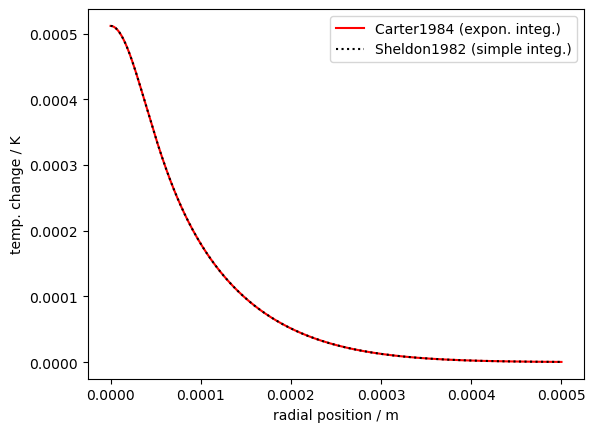

In [10]:
t = 0.1
plt.plot(rr1, DeltaT_Carter(rr1, t, P, w, k, t_c),
         'r-', label='Carter1984 (expon. integ.)')
plt.plot(rr0, DeltaT_Sheldon(rr0, t, P, w, k, cp, rho, t_c),
         'k:', label='Sheldon1982 (simple integ.)')
plt.xlabel('radial position / m')
plt.ylabel('temp. change / K')
plt.legend();

## Finite-volume solution with PyFVTool

In [11]:
# explicity import all required routines from pyfvtool
from pyfvtool import CylindricalGrid1D, BoundaryConditions
from pyfvtool import CellVariable
from pyfvtool import transientTerm, diffusionTerm
from pyfvtool import harmonicMean, boundaryConditionsTerm
from pyfvtool import constantSourceTerm
from pyfvtool import solveMatrixPDE

We will use the same system parameters and laser intensity function as above to ensure consistency.

In [12]:
# set FVM-specific parameters
Nr = 100 # number of FV cells
Lr = 10.0*w # width of domain (for now, simply evenly spaced. TODO: improve meshing)
T0 = 0. # initial rel. temperature
deltat = 0.001 # FVM time step

In [13]:
# TODO: more attention to alpha (see previously)
# for now, set to 1.0
alpha = 1.0

In [14]:
# create grid
mesh = CylindricalGrid1D(Nr, Lr)

In [15]:
bc = BoundaryConditions(mesh)
fv_T = CellVariable(mesh, T0, bc)

In [16]:
dotqval = alpha*S(mesh.cellcenters.x, P, w)
fv_dotq = CellVariable(mesh, dotqval)

AttributeError: This mesh has no coordinate labeled 'x'.

In [ ]:
fv_k_cell = CellVariable(mesh, k)
fv_k_face = harmonicMean(fv_k_cell)

In [ ]:
fv_transcoeff =  CellVariable(mesh, cp*rho)

In [ ]:
# create constant matrix contributions 
# (diffusion term, source term, boundary condition)
Mdiff = diffusionTerm(fv_k_face)
Mbc, RHSbc = boundaryConditionsTerm(bc)
RHSsrc = constantSourceTerm(fv_dotq)

In [ ]:
t = 0.
fv_T.value[:] = T0 # reset

rr0 = np.linspace(0, w*10, 500)
sample_i = [0, 1, 2, 5, 10, 20, 50, 100]
OKlegend = False
for i in range(0,101):
    if i in sample_i:
        r, phi = fv_T.plotprofile()
        ln0, = plt.plot(r, phi)
        ln1, = plt.plot(rr0, DeltaT_Sheldon(rr0, i*deltat, P, w, k, cp, rho, t_c), 'k:')
        if not OKlegend:
            OKlegend = True
            ln0.set_label('FVM')
            ln1.set_label('analytic')
    # create time-dependent matrix contributions (transientTerm)
    M_trans, RHS_trans = transientTerm(fv_T, deltat, fv_transcoeff)
    # assemble matrix equation
    M = M_trans - Mdiff + Mbc
    RHS = RHS_trans + RHSbc + RHSsrc
    # solve and update
    fv_T_new = solveMatrixPDE(mesh, M, RHS)
    fv_T.update_value(fv_T_new)
    t += deltat
if OKlegend:
    plt.legend()
plt.xlabel('radial position / m')
plt.ylabel('temp. change / K');

## Simple quantitative testing of numerical FV solution against analytic

In [ ]:
# take last calculated time `t`
r_num, phi_num = fv_T.plotprofile()
phi_an_r_num = DeltaT_Sheldon(r_num, t, P, w, k, cp, rho, t_c)
norm_err = (phi_num - phi_an_r_num)/phi_an_r_num.max()
plt.plot(r_num, norm_err, 'o')
plt.xlabel('radial position / m')
plt.ylabel('norm. error FV vs analytic');

In [ ]:
assert np.alltrue(np.abs(norm_err) < 0.0025)